# Generate optical flow from an image

In [1]:
import os
import datetime
from diffusers import UNet2DModel, DDPMScheduler
from models.motion_synthesis import VQModel_, generate_spectrum
from utils import *

if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

transforms = FrameSpectrumProcessing(num_freq=16)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.0015, beta_end=0.0195, beta_schedule="scaled_linear")
vae = VQModel_.from_pretrained("CompVis/ldm-celebahq-256", subfolder="vqvae").to(DEVICE).eval()
unet = UNet2DModel.from_pretrained("data/models/unet").to(DEVICE).eval()

out_dir = "data/unet_samples"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [2]:
# Load an image
image_path = "data/images/512px-001_2015_04_19_Das_Gelb_der_Natur.jpg"
frame_np = get_image(image_path, width=256, height=160, crop=True)
frame = transforms.process_frame(frame_np).unsqueeze(0).to(DEVICE)

# Generate motion spectrum
num_steps = 100

sample_name = "_".join([
    os.path.split(image_path)[1],
    "ddpm" + str(num_steps),
    datetime.datetime.now().isoformat().replace(":", "_")
])

spec_np = generate_spectrum(vae, unet, noise_scheduler, frame, num_steps=num_steps, batch_size=1)

path = os.path.join(out_dir, sample_name + ".npy")
save_npy(spec_np, path)
print(f"sample saved at {path}")

# Visualize the result
spec_image, video = visualize_sample(frame_np, spec_np, transforms, magnification=5.0, include_flow=True)

path = os.path.join(out_dir, sample_name + ".png")
spec_image.save(path)
print(f"spectrum image saved at {path}")

path = os.path.join(out_dir, sample_name + ".mp4")
video.write_videofile(path, logger=None)
print(f"video saved at {path}")

100%|██████████| 16/16 [05:20<00:00, 20.01s/it]


sample saved at data/unet_samples/512px-001_2015_04_19_Das_Gelb_der_Natur.jpg_ddpm100_2024-06-03T16_21_38.503213.npy
spectrum image saved at data/unet_samples/512px-001_2015_04_19_Das_Gelb_der_Natur.jpg_ddpm100_2024-06-03T16_21_38.503213.png
video saved at data/unet_samples/512px-001_2015_04_19_Das_Gelb_der_Natur.jpg_ddpm100_2024-06-03T16_21_38.503213.mp4


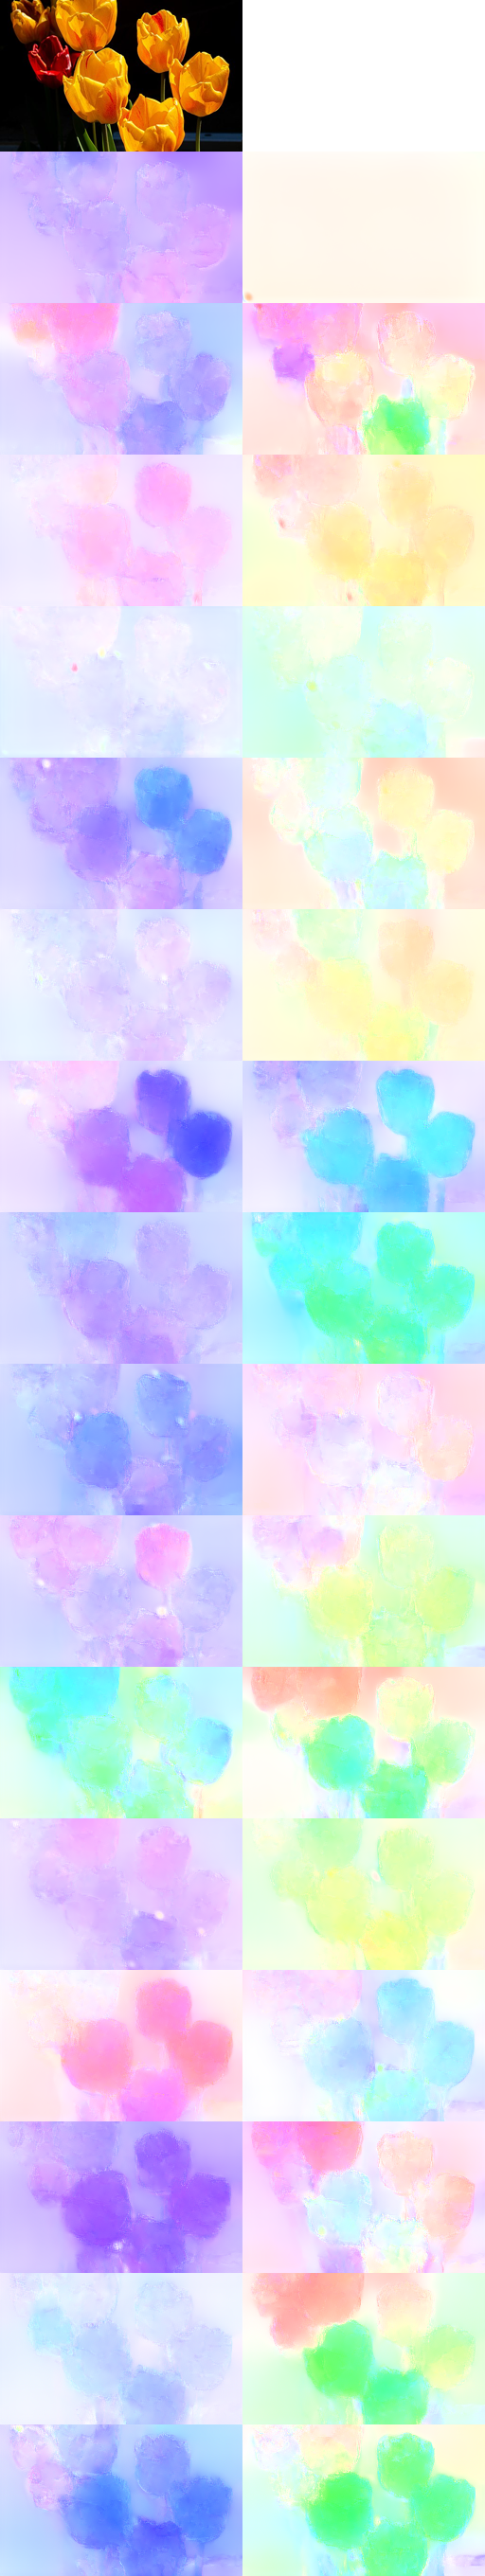

In [3]:
# Show generated FFT in an image. Each row shows a frequency with the real part on the left and the imaginary part on the right.
spec_image

In [27]:
# Show optical flow derived from generated spectrum and warped frames
video.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

# Generate video from image and optical flow

In [1]:
import datetime
import moviepy.editor as mpy
from models.frame_synthesis import *
from utils import *
from utils.flow import optical_flow
DEVICE = torch.device("cuda:0")

model = Synthesis()
model.load_state_dict(torch.load("data/models/frame_synthesis.pth")["model"])
model = model.to(DEVICE).eval()

transforms = FrameFlowProcessing()

In [2]:
# Load a 5-second frame sequence
video_path = "data/videos/Fleur_de_pommier_18.mp4"
start_sec = 5
fps = 30
num_frames = 150

frames = get_frames(video_path, w=256, h=160, start_sec=start_sec, fps=fps, f=num_frames)

# Show the sequence
clip = mpy.ImageSequenceClip(list(frames), fps=fps)
clip.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

In [3]:
# Estimate optical flow from the first frame to each frame
start_time = datetime.datetime.now()
flow = optical_flow(frames[0], frames[1:])
print(datetime.datetime.now() - start_time)

0:01:21.887495


In [4]:
# Visualize optical flow
flow_color = flow_to_color_video(flow)

clip = mpy.ImageSequenceClip(list(flow_color), fps=30)
clip.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

In [12]:
# Reconstruct the video from the first frame and optical flow
src_frame = transforms.process_frame(frames[0]).unsqueeze(0).to(DEVICE)
flow = transforms.process_flow(flow).to(DEVICE)
pred = predict_tensor(src_frame, flow, model, transforms, return_tensor=False)

clip = mpy.ImageSequenceClip(list(np.concatenate([
    add_video_title(frames[1:], "Original frames"),
    add_video_title(pred, "Model prediction")
], axis=2)), fps=30)
clip.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))